### Bibliotecas

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import osmnx as ox
import networkx as nx
from itertools import combinations
import multiprocessing as mp

print(f'Utilizando a versão {ox.__version__} do OSMNX')

print(f'Eu tenho {mp.cpu_count()} CPUs disponíveis')

Utilizando a versão 1.9.4 do OSMNX
Eu tenho 8 CPUs disponíveis


### Parâmetros

In [11]:
caminho = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/6_Qualificação/Mapas temáticos e figuras/BACIA_HIDROGRAFICA/SIRGAS_BACIAHIDROGRAFICA.shp'

my_crs = 'epsg:4326'  # Verificar em EPSG.io um projeção que te dê o resultado em metros

pesquisa_OD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Pesquisa OD 2017/OD-2017/Mapas-OD2017/Shape-OD2017/Zonas_2017_region.shp'
plt.style.use('ggplot')

arquivo_matrizOD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/4_Códigos/Dados/OD-2017/Tabelas-OD2017/Tab25_OD2017.xlsx'

verbose = True  # Flag para pular algumas atividades, com o objetivo de economizar memória.

ox.settings.log_console = True
ox.settings.use_cache = True

In [3]:
# Carregar o grafo de um arquivo GraphML e o bounding box
try:
    G_baseline = ox.load_graphml(filepath='network_baseline_vel_updated.graphml')
    print('Grafo carregado com sucesso!')
except:
    print('Arquivo não encontrado')

try:
    bounding_box_baseline = gpd.read_file('bounding_box_bacia.json')
    print('Bounding box carregado com sucesso!')
except:
    print('Bounding box não encontrado')
    
node_baseline, edges_baseline = ox.graph_to_gdfs(G_baseline)

Grafo carregado com sucesso!
Bounding box carregado com sucesso!


### Carregar os pontos da pesquisa OD referentes a bacia

In [37]:
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS, Transformer

# Read the shapefile
gdf_OD = gpd.read_file(pesquisa_OD)

# You need to understand Geographic coordinate systems and Projected coordinate systems.
# Geographic CRS(such as 'EPSG:4326') is not suitable for measuring distance. 
# Converting degree to distance requires additional work. 
# Use a different coordinate as the warning message shows. 
# The coordinates you usually use depend on the area you want to analyze.
# It will be common to use a coordinate system based on UTM.
    
# Verifica o sistema de coordenadas
gdf_OD.crs

# Define the UTM Zone 23S coordinate system
utm_crs = CRS("EPSG:32723")  # UTM Zone 23S, southern hemisphere

# Atribuição do esquema de projeção
gdf_OD_utm = gdf_OD.to_crs(utm_crs)

# Filtrando para o munícipio de São Paulo
gdf_OD_SP_utm = gdf_OD_utm[gdf_OD_utm['NomeMunici'] == 'São Paulo'].copy()

# Obtendo os centroides
gdf_OD_SP_utm["centroid"] = gdf_OD_SP_utm["geometry"].centroid

if verbose:
    mapa_centroides = gdf_OD_SP_utm['centroid'].explore()
    mapa_centroides.save('mapa_centroides_SP.html')

In [38]:
centroides_df = gpd.GeoDataFrame(gdf_OD_SP_utm[['NumeroZona', 'NomeZona']], geometry=gdf_OD_SP['centroid'])
centroides_dentro = gpd.sjoin(centroides_df, bounding_box_baseline, how='inner', predicate='within')

# Remover a coluna de índice criada pelo sjoin
centroides_dentro = centroides_dentro.drop(columns=['index_right'])

# Redefinir o índice
centroides_dentro = centroides_dentro.reset_index(drop=True)

centroides_dentro.shape

(65, 3)

In [54]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 1. Aproximar os pontos de centroides_dentro à rede
centroides_dentro['nearest_node_baseline'] = centroides_dentro['geometry'].apply(
    lambda point: ox.distance.nearest_nodes(G_baseline, point.x, point.y)
)

# Função para obter coordenadas dos nós
def get_node_coords(node_id):
    node = G_baseline.nodes[node_id]
    return (node['x'], node['y'])

# Adicionar coordenadas dos nós ao DataFrame
centroides_dentro['node_coords'] = centroides_dentro['nearest_node_baseline'].apply(get_node_coords)

# Separar coordenadas em colunas distintas
centroides_dentro[['node_x', 'node_y']] = pd.DataFrame(centroides_dentro['node_coords'].tolist(), index=centroides_dentro.index)

# Criar geometria dos pontos para o novo GeoDataFrame
geometry = [Point(xy) for xy in zip(centroides_dentro['node_x'], centroides_dentro['node_y'])]

# Criar o GeoDataFrame
gdf_nos_aproximados = gpd.GeoDataFrame(centroides_dentro, geometry=geometry, crs='EPSG:4326')

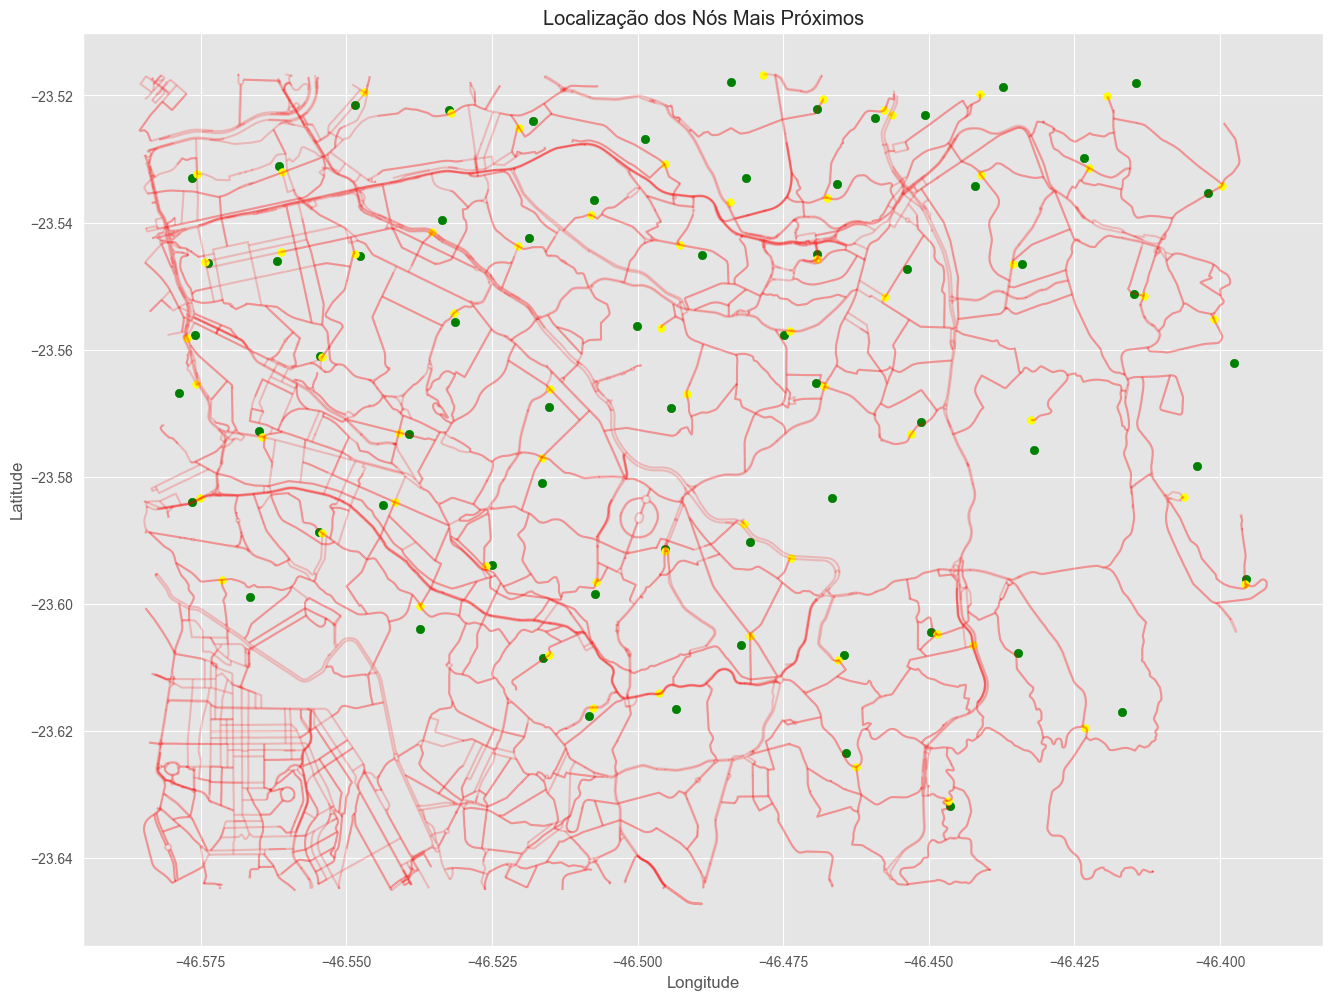

In [58]:
# Verificação gráfica do resultado
base2 = centroides_dentro.plot(color='green', figsize=(16,16))

# Atribuição do esquema de projeção
edges_baseline_utm = edges_baseline.to_crs(utm_crs)

edges_baseline.plot(ax=base2, color='red', alpha=0.2)

gdf_nos_aproximados.plot(ax=base2, marker='o', color='yellow', markersize=30)
plt.title('Localização dos Nós Mais Próximos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Calcular o baseline (caminhos mínimos, sem chuva)

In [59]:
def listar_atributos_arestas(G):
    atributos = set()
    for _, _, dados in G.edges(data=True):
        atributos.update(dados.keys())
    return atributos

In [70]:
# Função para adicionar tempo de viagem às arestas
def add_edge_travel_times(G, referencia, comentarios):
    if comentarios:
        print('\nIniciando o cálculo do tempo de viagem.\n')
    for u, v, key, data in G.edges(keys=True, data=True):
        length = data.get('length', 0)  # Certifique-se de que length esteja definido
        vel_ref = data.get(referencia, 0)  # Certifique-se de que vel_ref esteja definido
        
        if vel_ref == 0:
            travel_time_ref = float('inf')  # Indica que o tempo de viagem é infinito
        else:
            travel_time_ref = (length*3.6) / vel_ref  #*(3600/1000)  # Convertendo para segundos
        nome = 'travel_time_' + referencia
        G.edges[u, v, key][nome] = travel_time_ref
    
    if comentarios:
        print('Cálculo do tempo de viagem concluído.\n')
        print('Removendo arestas cujo tempo de viagem é igual a infinito...\n')
    edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if data.get(nome) == float('inf')]
    # Remover as arestas com tempo de viagem igual a infinito
    G.remove_edges_from(edges_to_remove)
    if comentarios:
        print(f'{len(edges_to_remove)} aresta(s) removida(s).\n')
    return G

In [72]:
# Adicionar velocidade aos eixos e calcular o tempo de viagem
referencia = 'speed_kph'
G_mod = add_edge_travel_times(G_baseline, referencia, comentarios=False)

In [66]:
import pandas as pd
import itertools
import time

# Carregar a planilha no DataFrame
# Considerando que a primeira linha contém os cabeçalhos e as zonas começam de 1
matriz_od_25 = pd.read_excel(arquivo_matrizOD, header=7, index_col=0)
# Exibir as primeiras linhas do DataFrame para verificação
print(matriz_od_25.head())

              1           2    3           4           5           6  \
NaN         NaN         NaN  NaN         NaN         NaN         NaN   
1    128.247095   86.383235  0.0  191.877452  105.088345  151.710615   
2     86.383235    0.000000  0.0    0.000000  612.400416  256.941702   
3      0.000000    0.000000  0.0    0.000000  194.857696    0.000000   
4      0.000000  214.428586  0.0  372.251396  455.222595    0.000000   

              7           8          9   10  ...  509  510  511  512  513  \
NaN         NaN         NaN        NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
1    234.477033    0.000000   0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0   
2      0.000000    0.000000  92.275009  0.0  ...  0.0  0.0  0.0  0.0  0.0   
3      0.000000    0.000000   0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0   
4      0.000000  159.375738   0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0   

     514  515        516  517         Total  
NaN  NaN  NaN        NaN  NaN           NaN  
1    0.0  0.

In [73]:
# 1. Função para obter o número de viagens da matriz OD
def get_number_of_trips(node1, node2, referencia, od_matrix):
    zone1 = centroides_dentro.loc[centroides_dentro[referencia] == node1, 'NumeroZona'].values[0]
    zone2 = centroides_dentro.loc[centroides_dentro[referencia] == node2, 'NumeroZona'].values[0]
    return od_matrix.loc[zone1, zone2]

In [74]:
# Definição da função para encontrar o caminho mínimo
def caminho_minimo(G, source, target, weight):
    # Encontrar o caminho mais curto
    path = nx.shortest_path(G, source=source, target=target, weight=weight)
    path_cost = nx.path_weight(G, path, weight=weight)
    return path, path_cost

In [116]:
 def calcula_caminho_minimo(gdf_OD, referencia_OD, G, referencia,comentarios):
    data = 0
    data_batch = []
    start_time = time.time()
    if comentarios:
        print('\nIniciando o cálculo do caminho mínimo médio.')
        print(f'A referência fornecida para o cálculo do custo é {referencia_OD}')
    for node1, node2 in itertools.product(gdf_OD[referencia_OD], repeat=2):
        if node1 == node2:
            continue  # Ignorar pares onde origem e destino são iguais
        try:
            # Obter o número de viagens entre node1 e node2
            num_trips = get_number_of_trips(node1, node2, referencia_OD, matriz_od_25)
            if num_trips > 0:
                # Calcular o caminho mínimo pelo tempo de viagem ponderado
                if node1 in G.nodes and node2 in G.nodes:
                    # Calcular o caminho mais curto
                    caminho, tempo = caminho_minimo(G, node1, node2, referencia)
                    weighted_time_rain = tempo * num_trips
                else:
                    print(f"Nó(s) {node1} ou {node2} não encontrado(s) no grafo.")
                    continue
                data_batch.append({
                    'index': data + 1,
                    'Origem': node1,
                    'Destino': node2,
                    'Num_viagens': num_trips,
                    'Tempo de viagem (min)': tempo / 60,
                    'Número de nós': len(caminho),
                    'Percurso entre nós': list(caminho),
                    'Tempo ponderado sem chuva (min)': weighted_time_rain / 60
                        })
                data += 1

        except nx.NetworkXNoPath:
            # Se não houver caminho entre os nós, ignore esse par
            continue
            
    # Parar o cronômetro e calcular o tempo de processamento
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"Tempo de processamento: {processing_time:.2f} segundos")
    print(f'Foram calculadas {data} viagens')
            
    # Criar DataFrame e salvar em CSV
    tempos_e_viagens_arquivo = pd.DataFrame(data_batch)
    return tempos_e_viagens_arquivo

In [117]:
tempos_e_viagens_arquivo = calcula_caminho_minimo(centroides_dentro,'nearest_node_baseline', G_mod, 'travel_time_speed_kph',comentarios=True)


Iniciando o cálculo do caminho mínimo médio.
A referência fornecida para o cálculo do custo é nearest_node_baseline
Tempo de processamento: 8.40 segundos
Foram calculadas 851 viagens


In [118]:
import numpy as np

# Filtrar os valores finitos para tempo com peso e num_viagens
finite_mask_baseline = np.isfinite(tempos_e_viagens_arquivo['Tempo ponderado sem chuva (min)'])
finite_tempos_e_viagens_baseline = tempos_e_viagens_arquivo[finite_mask_baseline]

# Calcular o número total de viagens sem valores infinitos
total_trips_weighted = finite_tempos_e_viagens_baseline['Num_viagens'].sum()

# Calcular o tempo total sem peso ignorando valores infinitos
total_time_weighted = finite_tempos_e_viagens_baseline['Tempo ponderado sem chuva (min)'].sum()

# Calcular o tempo médio de viagem ponderado
mean_time_weighted = total_time_weighted / total_trips_weighted

# Exibir os resultados
print(f"Tempo médio de viagem sem chuva e ponderado: {mean_time_weighted:.2f} minutos")


Tempo médio de viagem sem chuva e ponderado: 7.25 minutos


In [119]:
# Padronização dos números
tempos_e_viagens_arquivo['Num_viagens'] = tempos_e_viagens_arquivo['Num_viagens'].apply(lambda x: f"{x:.2f}")
tempos_e_viagens_arquivo['Tempo de viagem (min)'] = tempos_e_viagens_arquivo['Tempo de viagem (min)'].apply(lambda x: f"{x:.2f}")
tempos_e_viagens_arquivo['Tempo ponderado sem chuva (min)'] = tempos_e_viagens_arquivo['Tempo ponderado sem chuva (min)'].apply(lambda x: f"{x:.2f}")

In [120]:
# Salva o arquivo localmente
tempos_e_viagens_arquivo.to_csv('dados_caminho_minimo_sem_chuva.csv', encoding='utf-8', index=False)  # index=False para não incluir a coluna de índices no CSV

In [126]:
import networkx as nx
import folium
import pandas as pd

# Função para plotar a linha do dataframe no mapa
def plot_trip_on_map(df, row_index, G):
    row = df.iloc[row_index]
    origem = row['Origem']
    destino = row['Destino']
    percurso = row['Percurso entre nós']

    # Cria um mapa centrado na origem
    origem_coords = (G.nodes[origem]['lat'], G.nodes[origem]['lon'])
    m = folium.Map(location=origem_coords, zoom_start=13)

    # Adiciona um marcador para a origem
    folium.Marker(origem_coords, popup=f"Origem: {origem}", icon=folium.Icon(color='green')).add_to(m)

    # Adiciona um marcador para o destino
    destino_coords = (G.nodes[destino]['lat'], G.nodes[destino]['lon'])
    folium.Marker(destino_coords, popup=f"Destino: {destino}", icon=folium.Icon(color='red')).add_to(m)

    # Adiciona linhas entre os nós do percurso
    percurso_coords = [(G.nodes[node]['lat'], G.nodes[node]['lon']) for node in percurso]
    folium.PolyLine(percurso_coords, color="blue", weight=2.5, opacity=1).add_to(m)

    return m

In [127]:
map = plot_trip_on_map(tempos_e_viagens_arquivo, 0, G_baseline)  # Plota a linha de índice 0 do DataFrame
# map.save('map.html')  # Salva o mapa em um arquivo HTML
map  # Exibe o mapa no Jupyter Notebook

KeyError: 'lat'

In [113]:
caminho, tempo = caminho_minimo(G_baseline, 340185206, 4499663530, 'travel_time_speed_kph')

In [115]:
list(caminho)

[340185206,
 910203189,
 1759958160,
 340185200,
 470094120,
 1420391122,
 470094118,
 138112453,
 2384780814,
 445062700,
 1420286026,
 1421325180,
 352693672,
 334383138,
 4499663530]

In [134]:
import momepy

points, line = momepy.nx_to_gdf(G_baseline)

/var/folders/8y/8z4lzw294m5c0kf05d8ww4r00000gn/T/ipykernel_14385/4062358950.py:3: UserWarning: Approach is not set. Defaulting to 'primal'.
  points, line = momepy.nx_to_gdf(G_baseline)


<Axes: >

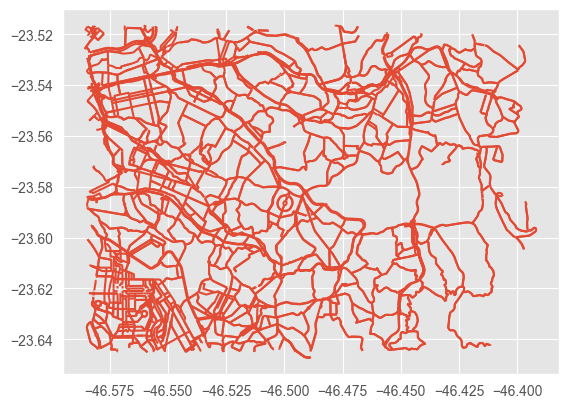

In [136]:
line.plot()